In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd 

import MuC.MuC as MuC
from MuC import collider_tools as col
from MuC import plot_tools as pt

from DarkNews import Cfourvec as Cfv

## Generate some benchmark cases

In [ ]:
NEVENTS = 1e6

col_designs = [col.muc_10tev, col.muc_3tev, col.mut_2tev]
col_sims = []
for design in col_designs:
    if design == col.muc_10tev:
        sim = MuC.BINSimulator(design=design, N_evals = NEVENTS, save_mem=False, remove_ring_fraction=0.9, lattice='beam-optics/ring_v06_smoothed.pkl')
    elif design == col.muc_3tev or design == col.mut_2tev:
        sim = MuC.BINSimulator(design=design, N_evals = NEVENTS, save_mem=False, remove_ring_fraction=0.9, lattice='beam-optics/ring_3tev_v1.2_smoothed.pkl')
    else:
        sim = MuC.BINSimulator(design=design, N_evals = NEVENTS, save_mem=False, remove_ring_fraction=0.9, lattice=None)
    col_sims.append(sim.run())

Efficiency of detector acceptance: 2.19e-01
Efficiency of detector acceptance: 2.20e-01
Efficiency of detector acceptance: 2.20e-01
Efficiency of detector acceptance: 2.20e-01
Total count: 1.51e+11 events;

Efficiency of detector acceptance: 4.00e-01
Efficiency of detector acceptance: 4.07e-01
Efficiency of detector acceptance: 4.01e-01
Efficiency of detector acceptance: 4.06e-01
Total count: 1.99e+10 events;

Efficiency of detector acceptance: 3.83e-01
Efficiency of detector acceptance: 3.89e-01
Efficiency of detector acceptance: 3.83e-01
Efficiency of detector acceptance: 3.90e-01
Total count: 1.65e+11 events;



In [ ]:
for c in col_sims:
    print(c.bunchx_in_a_year/c.design['finj']/c.design['Nmu_per_bunch']/c.design['bunch_multiplicity'])

0.038425516261336494
0.07678412133007491
0.9977949650846266


#### Save this event generation if desired

In [ ]:
def get_all_flavors(dic, channel, flavors=["nue","numu","nuebar","numubar"]):
    if channel == "CC":
        return pt.sci_notation(np.sum([dic[flavor,'CC_light'] for flavor in flavors]) + np.sum([dic[flavor,'CC_charm'] for flavor in flavors]), 1, 1)
    else:
        if isinstance(channel,list) or isinstance(channel,tuple):
            return pt.sci_notation(np.sum([dic[flavor,chan] for flavor in flavors for chan in channel]), 1, 1)
        else:
            return pt.sci_notation(np.sum([dic[flavor,channel] for flavor in flavors]), 1, 1)

def get_all_flavors_multichannel(dic, channels, flavors=["nue","numu","nuebar","numubar"]):
    total = 0
    for channel in channels:
        total += np.sum([dic[flavor,channel] for flavor in flavors])
    return pt.sci_notation(total, 1, 1)


In [ ]:
version = 'MH_Dec11'
for design, sim in zip(col_designs, col_sims):
    with open(f'gen_data/{version}_{design["short_name"]}.pkl', 'wb') as f:
        pickle.dump(sim, f)

In [ ]:
col_sims_small = col_sims

perc = "\%"
ncases=len(col_sims)
S = fr"""
\begin{{table}}[t]
  \centering
  \renewcommand{{\arraystretch}}{{1.25}}
  \begin{{ruledtabular}}
  \begin{{tabular}}{{l{ncases*'c'}}}
     $\nu+\bar\nu$ Rates 
     {''.join([f'& {c.design["name"].replace(" 2 TeV", "")} ' for c in col_sims_small])}
    \\
    \hline
    NC
    {''.join([f'& {get_all_flavors(c.exclusive_rates_combined, "NC")} ' for c in col_sims_small])}
    \\
    $\nu_e$ CC
    {''.join([f'& {get_all_flavors(c.exclusive_rates_combined, "CC", flavors=["nue","nuebar"])} ' for c in col_sims_small])}
    \\
    $\nu_\mu$ CC
    {''.join([f'& {get_all_flavors(c.exclusive_rates_combined, "CC", flavors=["numu","numubar"])} ' for c in col_sims_small])}
    \\
    ES $\nu e \to \nu e$
    {''.join([f'& {get_all_flavors(c.exclusive_rates_combined, "ES_e", flavors=["nue","numu","nuebar","numubar"])} ' for c in col_sims_small])}    
    \\
    IMD $\nu e \to \nu \mu$
    {''.join([f'& {get_all_flavors(c.exclusive_rates_combined, "invdecay_mu", flavors=["numu","nuebar"])} ' for c in col_sims_small])}
    \\
    Trident $\nu A \to \nu \ell \ell A$
    {''.join([f'& {get_all_flavors_multichannel(c.exclusive_rates_combined, ["eee_tri","mee_tri","eme_tri","mem_tri","emm_tri","mmm_tri","ell_tri","mll_tri"])} ' for c in col_sims_small])}
    \\ \hline
    Total/(bunch cross.)
    {''.join([f'& {pt.sci_notation((c.facecounts["EC","Total"]+c.facecounts["HC","Total"])/c.bunchx_in_a_year, 1, 1)}' for c in col_sims_small])}
    \\
\end{{tabular}}
  \end{{ruledtabular}}
  \caption{{Total number of neutrino interactions in proposed muon colliders.
  Rates are given for total neutrino and antineutrino composition. Here, ES = elastic scattering, IMD = inverse muon decay, Trident = neutrino trident production on the Coulomb field of nuclei.}}
  \label{{tab:event_rate_makeup}}
\end{{table}}
"""
np.savetxt("event_rate_makeup_small.tex", [S], fmt="%s")

In [ ]:
perc = "\%"
ncases=len(col_sims)
S = fr"""
\begin{{table*}}[t]
  \centering
  \renewcommand{{\arraystretch}}{{1.25}}
  \begin{{ruledtabular}}
  \begin{{tabular}}{{l{ncases*'c'}}}
     Collider 
     {''.join([f'& {c.design["name"]} ' for c in col_sims])}
    \\
    \hline
        Beams 
        {''.join([f'& {col.acc_colls_dict[c.design["collision_type"]]}' for c in col_sims])}
    \\  
        Muons/bunch 
        {''.join([f'& {pt.sci_notation(c.design["Nmu_per_bunch"],1,1)} ' for c in col_sims])}
    \\  
        bunches/cycle
        {''.join([f'& {int(c.design["bunch_multiplicity"]):d} ' for c in col_sims])}
    \\  
        $f_{{\rm inj}}$
        {''.join([f'& {c.design["finj"]:d}~Hz' for c in col_sims])}
    \\  
        $C$
        {''.join([f'& {c.C/1e5:.1f}~km' for c in col_sims])}
    \\  
    \hline\hline
    \multicolumn{ncases+1}{{c}}{{Beam-induced neutrino interaction rate}}
    \\
    \hline
    ECal ($0.15$~kt)
    {''.join([f'& {c.facecounts["EC","Total"]/c.facecounts["Total","Total"]*100:.1f}{perc} ' for c in col_sims])}
    \\
    HCal ($1.4$~kt)
    {''.join([f'& {c.facecounts["HC","Total"]/c.facecounts["Total","Total"]*100:.0f}{perc} ' for c in col_sims])}
    \\
    Muon Sys ($7.5$~kt)
    {''.join([f'& {c.facecounts["MD","Total"]/c.facecounts["Total","Total"]*100:.0f}{perc} ' for c in col_sims])}
    \\
    Nozzles $(0.14$~kt)
    {''.join([f'& {c.facecounts["NO","Total"]/c.facecounts["Total","Total"]*100:.0f}{perc} ' for c in col_sims])}
    \\
    \hline
    Total / bunch cross. 
    {''.join([f'& {c.facecounts["Total","Total"]/c.bunchx_in_a_year:.2g} ' for c in col_sims])}
    \\
    Total / year
    {''.join([f'& {pt.sci_notation(c.facecounts["Total","Total"], 1, 1)} ' for c in col_sims])}
    \\
    \hline\hline
    \multicolumn{ncases+1}{{c}}{{Rates of exclusive channels in HCAL and ECAL per year}}
    \\
    \hline
    Total NC
    {''.join([f'& {get_all_flavors(c.exclusive_rates_combined, "NC")} ' for c in col_sims])}
    \\
    Total $\nu_e$ CC
    {''.join([f'& {get_all_flavors(c.exclusive_rates_combined, "CC", flavors=["nue","nuebar"])} ' for c in col_sims])}
    \\
    Total $\nu_\mu$ CC
    {''.join([f'& {get_all_flavors(c.exclusive_rates_combined, "CC", flavors=["numu","numubar"])} ' for c in col_sims])}
    \\
    \hline
    ES $\nu_{{e}} e \to \nu_{{e}} e$ 
    {''.join([f'& {get_all_flavors(c.exclusive_rates_combined, "ES_e", flavors=["nue"])} ' for c in col_sims])}    
    \\
    ES $\nu_{{\mu}} e \to \nu_{{\mu}} e$     
    {''.join([f'& {get_all_flavors(c.exclusive_rates_combined, "ES_e", flavors=["numu"])} ' for c in col_sims])}    
    \\
    ES $\overline\nu_{{e}} e \to \overline\nu_{{e}} e$ 
    {''.join([f'& {get_all_flavors(c.exclusive_rates_combined, "ES_e", flavors=["nuebar"])} ' for c in col_sims])}    
    \\
    ES $\overline\nu_{{\mu}} e \to \overline\nu_{{\mu}} e$     
    {''.join([f'& {get_all_flavors(c.exclusive_rates_combined, "ES_e", flavors=["numubar"])} ' for c in col_sims])}    
    \\\hline
    QE $\nu n \to \ell^- p^+$ 
    {''.join([f'& {get_all_flavors(c.exclusive_rates_combined, "QE", flavors=["numu","nue"])} ' for c in col_sims])}
    \\
    QE $\overline\nu p^+ \to \ell^+ n$ 
    {''.join([f'& {get_all_flavors(c.exclusive_rates_combined, "QE", flavors=["numubar","nuebar"])} ' for c in col_sims])}
    \\
    Coherent $\nu A \to \nu \pi^0 A$ 
    {''.join([f'& {get_all_flavors(c.exclusive_rates_combined, "pi0_coh")} ' for c in col_sims])}
    \\
    Resonant $\overline\nu_{{e}} e \to \rho^- \to \pi^- \pi^0$     
    {''.join([f'& {get_all_flavors(c.exclusive_rates_combined, "resonant_rho-", flavors=["nuebar"])} ' for c in col_sims])}    
    \\
    Resonant $\overline\nu_{{e}} e \to K^{{*-}} \to K^- \pi^0$     
    {''.join([f'& {get_all_flavors(c.exclusive_rates_combined, "resonant_Kstar-", flavors=["nuebar"])} ' for c in col_sims])}    
    \\\hline
    IMD $\nu_\mu e \to \nu_e \mu^-$ 
    {''.join([f'& {get_all_flavors(c.exclusive_rates_combined, "invdecay_mu", flavors=["numu"])} ' for c in col_sims])}
    \\  
    IMD $\overline\nu_e e \to \overline\nu_\mu \mu^-$ 
    {''.join([f'& {get_all_flavors(c.exclusive_rates_combined, "invdecay_mu", flavors=["nuebar"])} ' for c in col_sims])}
    \\  
    ITD $\overline\nu_e e \to \overline\nu_\tau \tau^-$ 
    {''.join([f'& {get_all_flavors(c.exclusive_rates_combined, "invdecay_tau", flavors=["nuebar"])} ' for c in col_sims])}
    \\\hline
    Trident $\nu A \to \nu e^+e^- A$ 
    {''.join([f'& {get_all_flavors(c.exclusive_rates_combined, ["eee_tri","mee_tri"])} ' for c in col_sims])}
    \\
    Trident $\nu A \to \nu \mu^\pm e^\mp A$ 
    {''.join([f'& {get_all_flavors(c.exclusive_rates_combined, ["eme_tri","mem_tri"])} ' for c in col_sims])}
    \\
    Trident $\nu A \to \nu \mu^+\mu^- A$ 
    {''.join([f'& {get_all_flavors(c.exclusive_rates_combined, ["emm_tri","mmm_tri"])} ' for c in col_sims])}
    \\
    Trident $\nu A \to \nu \tau^+\tau^- A$ 
    {''.join([f'& {get_all_flavors(c.exclusive_rates_combined, ["ell_tri","mll_tri"])} ' for c in col_sims])}
    \\\hline
\end{{tabular}}
  \end{{ruledtabular}}
  \caption{{Total number of neutrino interactions in proposed muon collider detectors. The makeup of the event rate is shown as percentages for each detector component, excluding the magnetic solenoid.
  Rates for some exclusive scattering channels are also shown, including elastic scattering (ES), coherent $\pi^0$ production, resonant meson production on electrons, quasi-elastic (QE) neutrino scattering, inverse muon decay (IMD), inverse tau decay (ITD), and neutrino trident production on the Coulomb field of the nucleus.}}
  \label{{tab:event_rate_makeup}}
\end{{table*}}
"""
np.savetxt("event_rate_makeup.tex", [S], fmt="%s")

In [ ]:
for csim in col_sims:
    print(csim.design['name'])
    print(csim.print_face_counts(percentage=True))
    for sim in csim.sims:
        sim.get_exclusive_rates()
        print(sim.print_exclusive_counts())

MuC 10 TeV
+------------------+----------+----------+--------------+------------+--------------+
|  Det component   |  Total   | nue_left | nuebar_right | numu_right | numubar_left |
+------------------+----------+----------+--------------+------------+--------------+
|       ecal       |  0.95%   |  0.96%   |    0.95%     |   0.96%    |    0.91%     |
|       hcal       |   6.7%   |   6.7%   |     6.7%     |    6.7%    |     6.5%     |
|  muon_detector   |   13%    |   13%    |     13%      |    13%     |     13%      |
|     nozzles      |   79%    |   79%    |     79%      |    79%     |     79%      |
| solenoid_borders |  0.23%   |  0.23%   |    0.23%     |   0.23%    |    0.23%     |
|   solenoid_mid   |  0.34%   |  0.34%   |    0.32%     |   0.34%    |    0.34%     |
|      Total       | 1.51e+11 | 4.38e+10 |   2.61e+10   |  5.07e+10  |   3.05e+10   |
|   Total/bunchx   | 4.37e-01 | 1.27e-01 |   7.55e-02   |  1.46e-01  |   8.81e-02   |
+------------------+----------+----------+-

## Timing plots

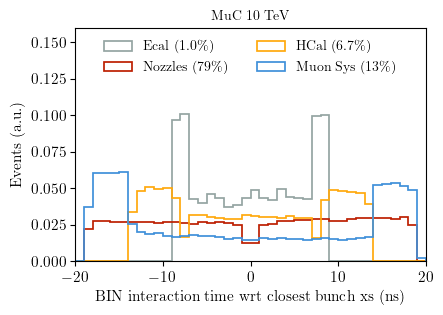

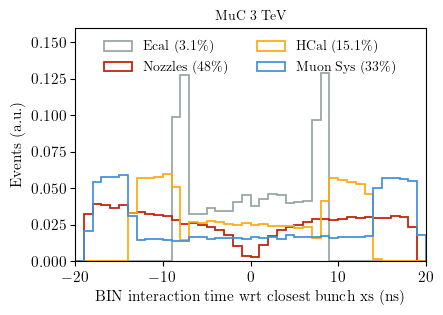

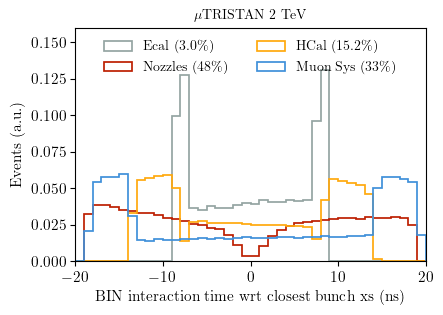

In [ ]:
for sim in col_sims:
    _, _, _, wms, timesms, _, _ = sim.get_data(sec = 'muon_detector')
    _, _, _, wno, timesno, _, _ = sim.get_data(sec = 'nozzles')
    _, _, _, whc, timeshc, _, _ = sim.get_data(sec = 'hcal')
    _, _, _, wec, timesec, _, _ = sim.get_data(sec = 'ecal')
    _, _, _, wsol, timesec_sol, _, _ = sim.get_data(sec = 'solenoid_borders')

    wtot = (wms.sum() + wno.sum() + whc.sum() + wec.sum() + wsol.sum())

    fig, ax = pt.std_fig()

    bucket_time = 20 # ns
    units=1e9 # ns
    bins = np.linspace(-bucket_time, bucket_time, 2*bucket_time+1, endpoint=True)
    data = [timesms, timeshc, timesno, timesec, timesec_sol]
    data = [d*units for d in data]
    weights = [wms/sim.bunchx_in_a_year, whc/sim.bunchx_in_a_year, wno/sim.bunchx_in_a_year, wec/sim.bunchx_in_a_year, wsol/sim.bunchx_in_a_year]
    colors = [c for c in pt.cblind_safe_wheel][:5]
    labels = [fr'Muon Sys ({100*wms.sum()/wtot:.0f}\%)', fr'HCal ({100*whc.sum()/wtot:.1f}\%)', fr'Nozzles ({100*wno.sum()/wtot:.0f}\%)', fr'Ecal ({100*wec.sum()/wtot:.1f}\%)', fr'Solenoid ({100*wsol.sum()/wtot:.1f}\%)' ]

    ax.hist(data[:-1], weights = weights[:-1], bins = bins, histtype = 'step', color = colors[:-1], label = labels[:-1], stacked = False, alpha=1, lw=1.25, density=True)
    # ax.hist(data[:-1], weights = weights[:-1], bins = 100, histtype = 'step', color = colors[:-1], label = labels[:-1], stacked = False, alpha=1, lw=1.25, density=False)
    # for data, weights, colors, labels in zip(data, weights, colors, labels):
        # ax.hist(data, weights = weights, bins = bins, histtype = 'stepfilled', edgecolor = 'black', facecolor = colors, label = labels, stacked=True, alpha=1, lw=0.5)
        # ax.hist(data, weights = weights, bins = bins, histtype = 'step', edgecolor = 'black', color = colors, stacked = True, alpha=1, lw=0.75)

    ax.legend(loc = 'upper center', ncol=2, fontsize=10, frameon=False)
    ax.set_ylabel(r'Events (a.u.)')
    ax.set_xlabel('BIN interaction time wrt closest bunch xs (ns)')
    # ax.set_ylim(0 ,0.001)
    ax.set_ylim(0,0.16)
    ax.set_xlim(bins.min(), bins.max())
    # ax.set_yscale('log')
    ax.set_title(sim.design["name"], fontsize=10)
    fig.savefig(f'plots/BIN_distributions/nu_times_{sim.design["short_name"]}.pdf', bbox_inches = 'tight', dpi = 500)

## Correlations between radius and time

0.6352051169432353 2.5461308822093893 31.000091931246555 170.19997036298352


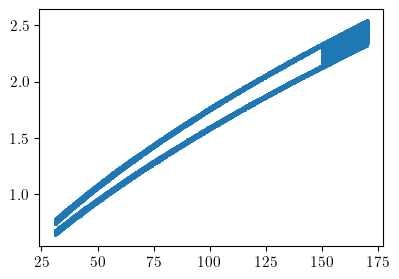

In [ ]:
x, y, z, w, times, Enu, costheta = col_sims[1].get_data(sec = 'ecal')

r = np.sqrt(x**2 + y**2)
angle = np.arccos(costheta)*180/np.pi
print(angle.min(), angle.max(), r.min(), r.max())

plt.plot(r, angle, 'o', markersize=1)
# plt.xlim(0,15)

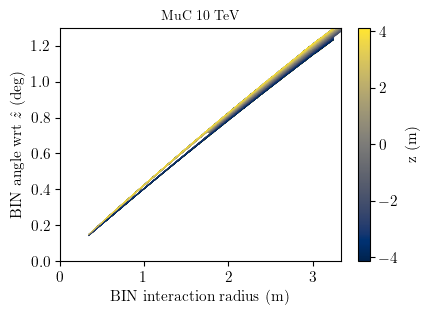

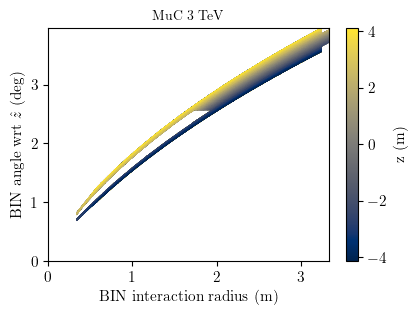

In [ ]:
for sim in col_sims[:2]:
    
    x, y, z, w, times, Enu, costheta = sim.get_data(sec = 'hcal')

    fig, ax = pt.std_fig()
    LS = (1,(3,0.5))
    LW = 1.5

    nbins = 400
    r_bins = np.linspace(2.2,350,nbins)
    if sim == col_sims[0]:
        theta_bins = np.linspace(0,1.5,nbins)
    else:
        theta_bins = np.linspace(0,4,nbins)
        
    yunits=1e9
    xunits = 1

    kwargs = {'histtype': 'step', 'lw': LW, 'bins': bins, 'cumulative': False, 'density': True}

    r = np.sqrt(x**2 + y**2)
    mask1 = (-600 < z) & (r > 15)
    # h = ax.hist2d(r[mask1], np.arccos(costheta[mask1])*180/np.pi, weights =-z[mask1], bins=[r_bins, theta_bins], cmap='cividis')
    theta = np.arccos(costheta)*180/np.pi
    c = ax.scatter(r[mask1]/100, theta[mask1], c=z[mask1]/100, cmap='cividis', s=0.5, lw=0, marker='.', rasterized=True)   
    cbar = fig.colorbar(c, ax=ax)
    # cbar = fig.colorbar(h[3], ax=ax)
    cbar.set_label('z (m)')

    # mask1 = (-600 < z) & (z < -200)
    # # ax.hist2d(r[mask1], np.arccos(costheta[mask1])*180/np.pi, weights = np.log10(w[mask1]), bins=[r_bins, theta_bins], cmin=0, cmap='cividis')
    # ax.scatter(r[mask1][:100_000], np.arccos(costheta[mask1][:100_000])*180/np.pi, c=np.log10(z[mask1][:100_000]), cmap='Reds', s=2)

    ax.set_ylabel(r'BIN angle wrt $\hat{z}$ (deg)')
    ax.set_xlabel(r'BIN interaction radius (m)')

    # ax.set_xscale('log')
    # ax.set_yscale('log')

    # Loop over axes and annotate
    ax.set_title(sim.design['name'], fontsize=10)
    
    ax.set_xlim(0*r.min()/100, r.max()/100) 
    ax.set_ylim(0*theta.min(), theta.max()) 

    # Adjust labels and layout
    fig.savefig(f'plots/BIN_distributions/radius_v_angle_{sim.design["short_name"]}.png', bbox_inches = 'tight', dpi = 500)

## Plot lattices and event locations

In [ ]:
df_10tev = pd.read_pickle('beam-optics/ring_v06_df.pkl')
df_3tev = pd.read_pickle('beam-optics/ring_3tev_v1.2_df.pkl')

/var/folders/dl/ccbsfs591r1fhgcws28m8xy40000gn/T/ipykernel_12694/1476606793.py:18: RuntimeWarning: divide by zero encountered in scalar divide
  r_arc = s/dtheta
/var/folders/dl/ccbsfs591r1fhgcws28m8xy40000gn/T/ipykernel_12694/1476606793.py:18: RuntimeWarning: invalid value encountered in scalar divide
  r_arc = s/dtheta


vmin: 4.534909750585913, vmax: 4002213079.174183
vmin: 36.584405760168615, vmax: 26796543.960513256


/var/folders/dl/ccbsfs591r1fhgcws28m8xy40000gn/T/ipykernel_12694/3655209498.py:63: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1a.set_yticklabels(ax.get_yticklabels(), fontsize=9)
/var/folders/dl/ccbsfs591r1fhgcws28m8xy40000gn/T/ipykernel_12694/3655209498.py:70: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=9)
/var/folders/dl/ccbsfs591r1fhgcws28m8xy40000gn/T/ipykernel_12694/3655209498.py:71: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=9)
/var/folders/dl/ccbsfs591r1fhgcws28m8xy40000gn/T/ipykernel_12694/3655209498.py:70: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a Fix

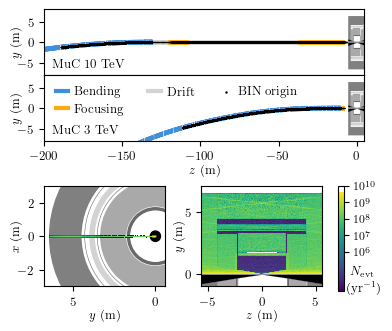

In [ ]:
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker

# from mpl_toolkits.axes_grid1 import make_axes_locatable
# fig, axs = plt.subplots(2, 2, figsize = (4.0, 3.8))
fig = plt.figure(figsize=(4.0, 3.3))
gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 2], width_ratios=[1, 1])
CMAP = 'viridis'

ax1a = plt.subplot(gs[0,:])
ax1b = plt.subplot(gs[1,:])
ax2 = plt.subplot(gs[2,0])
ax3 = plt.subplot(gs[2,1])

MuC.beam_optics.plot_lattice(df_10tev, ax1a, units=100, draw_center_line=False)
MuC.beam_optics.plot_lattice(df_3tev, ax1b, units=100, draw_center_line=False)

col1 = col_sims[0]
col2 = col_sims[1]

ax1b.plot([], [], lw=3, color = pt.cblind_safe_wheel[0], label = r"Bending")
ax1b.plot([], [], lw=3, color = pt.cblind_safe_wheel[1], label = r"Focusing")
ax1b.plot([], [], lw=3, color = 'lightgrey', label = r"Drift")
# ax1b.scatter([], [], facecolor = 'black', s=5, marker='.', linewidth=1, label = r"Muon decay")

nmax=int(1e6)
ax1a.scatter((col1.sims[0]).intersection_points[:,0,2][:nmax], (col1.sims[0]).intersection_points[:,0,1][:nmax], s = 3, marker='.', linewidth=0, c = 'black', rasterized=True)
ax1b.scatter((col2.sims[0]).intersection_points[:,0,2][:nmax], (col2.sims[0]).intersection_points[:,0,1][:nmax], s = 3, marker='.',  linewidth=0, c = 'black', rasterized=True, label = r"BIN origin")

ax1b.legend(fontsize=9, loc='upper left', handlelength=1, handletextpad=0.5, markerscale=2, ncol=3)

pt.plot_det('det_v2', ax = ax1a)
pt.plot_det('det_v2', ax = ax1b)

for ax1 in [ax1a, ax1b]:
    ax1.set_ylim(-800, 800)
    ax1.set_xlim(-200e2, 500)

# units = 1e2 #cm
collider = col_sims[1]

hist1 = collider.plot(cmap=CMAP, orientation='y-x', fs=None, ax=ax2, colorbar=0, h=True, cmin=1, title=False, nbins=400)
hist2 = collider.plot(cmap=CMAP, orientation='z-y', fs=None, ax=ax3, colorbar=0, h=True, title=0, cmin=1, nbins=400)

ax1a.set_ylabel(r'$y$ (m)', labelpad=-3, fontsize=9)
ax1b.set_ylabel(r'$y$ (m)', labelpad=-3, fontsize=9)
ax1b.set_xlabel(r'$z$ (m)', labelpad=1, fontsize=9)

ax2.set_ylabel(r'$x$ (m)', labelpad=-3, fontsize=9)
ax2.set_xlabel(r'$y$ (m)', labelpad=1, fontsize=9)

ax3.set_ylabel(r'$y$ (m)', labelpad=-0, fontsize=9)
ax3.set_xlabel(r'$z$ (m)', labelpad=1, fontsize=9)

ax2.set_xlim(collider.rmax*1.05,-60)
ax3.set_ylim(-100,collider.rmax*1.1)
ax2.set_ylim(-300, 300)
ax3.set_xlim(-collider.zending,collider.zending)

ax1a.set_xticklabels([])
ax1a.set_yticklabels(ax.get_yticklabels(), fontsize=9)
ticks_y = ticker.FuncFormatter(lambda y, pos: r'${0:g}$'.format(y/100))
ax1a.yaxis.set_major_formatter(ticks_y)

for ax in [ax1b, ax2, ax3]:
    # ax.set_xticks(ax.get_xticks(), fontsize)
    # ax.set_yticks(ax.get_yticks(), fontsize)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=9)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=9)
    
    ticks_x = ticker.FuncFormatter(lambda x, pos: r'${0:g}$'.format(x/100))
    ax.xaxis.set_major_formatter(ticks_x)
    ticks_y = ticker.FuncFormatter(lambda y, pos: r'${0:g}$'.format(y/100))
    ax.yaxis.set_major_formatter(ticks_y)    
# ax3.set_yticklabels([])

# ax2.text(-2.8e2, 5e2, r'$z=0$')
# ax3.text(-500, 500, r'$x=0$')

# Add a colorbar that spans both subplots

fig.subplots_adjust(hspace=0.4, wspace=0.3, right=0.82)
cbar_ax = fig.add_subplot(111)  # Create a new subplot for the colorbar
cbar = fig.colorbar(hist1[3], ax=[ax2, ax3], cax=cbar_ax)  # Create the colorbar
cbar_ax.set_position([0.86, 0.095, 0.015, 0.32])
cbar_ax.set_yticks([1e6, 1e7, 1e8, 1e9, 1e10])
cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(), fontsize=8)
cbar_ax.text(1.4, 4e4, r'\noindent \,\,$N_{\rm evt}$\\(yr$^{-1}$)', fontsize=9)

ax1a.text(-195e2, -7e2, r'MuC 10 TeV', fontsize=9, verticalalignment='bottom', horizontalalignment='left')
ax1b.text(-195e2, -7e2, r'MuC 3 TeV', fontsize=9, verticalalignment='bottom', horizontalalignment='left')

ax1a.set_position([0.125, 0.07+0.68, 0.8, 0.2])
ax1b.set_position([0.125, 0.07+0.68-0.2, 0.8, 0.2])
fig.savefig('plots/BIN_distributions/BIN_locations.pdf', dpi = 500, bbox_inches = 'tight')
fig.savefig('plots/BIN_distributions/BIN_locations.png', dpi = 500, bbox_inches = 'tight')

## Opening angle between the neutrino and the parent muon

NOTE: This is not the angle of the neutrino wrt to the tangent

(0.0, 4.0)

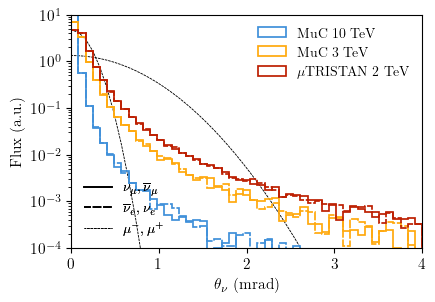

In [ ]:
bins = np.linspace(0,4,50)
light_factor = 1
LW=1.25
units = 1e3 # mrad
fig, ax = pt.std_fig()

kwargs = {'zorder': 2, 'lw': LW, 'histtype': 'step', 'bins': bins, 'cumulative': False, 'density': True}
def plot_curve(i, color=None):
    if color is None:
        color=i
    ax.hist(units*np.arccos(Cfv.get_cos_opening_angle(col_sims[i].mustorage_sims[1].pnu, col_sims[i].mustorage_sims[1].pmu)), weights = col_sims[i].mustorage_sims[1].weights, label = col_sims[i].design['name'], color = pt.cblind_safe_wheel[color], **kwargs)
    ax.hist(units*np.arccos(Cfv.get_cos_opening_angle(col_sims[i].mustorage_sims[0].pnu, col_sims[i].mustorage_sims[0].pmu)), weights = col_sims[i].mustorage_sims[0].weights, color = pt.lighten_color(pt.cblind_safe_wheel[color],light_factor), ls=(1,(5,1)), **kwargs)

plot_curve(0)
plot_curve(1)
plot_curve(2)

def gauss(x, mu, sigma):
    return 2/np.sqrt(2 * np.pi * sigma**2) * np.exp(-np.power(x - mu, 2.) / (2 * np.power(sigma, 2.)))

ax.plot(bins, gauss(bins, 0, 6e-4*units), color = 'black', lw = LW*0.5, ls=(1,(3,1)), zorder = 1)  #label = 'Gaussian ($\sigma = 0.60$~mrad)')
ax.plot(bins, gauss(bins, 0, 1.70e-4*units), color = 'black', lw = LW*0.5, ls=(1,(3,1)), zorder = 1)  #label = 'Gaussian ($\sigma = 0.17$~mrad)')
# standard legend
leg1 = ax.legend(loc = 'upper right')


# Create a new legend
dark_line = plt.Line2D([], [], color='black', lw=LW, label=r'$\nu_\mu,\overline\nu_\mu$')
light_line = plt.Line2D([], [], color='black', lw=LW, ls=(1,(5,1)), label=r'$\overline\nu_e,\nu_e$')
lighter_line = plt.Line2D([], [], color='black', lw=LW/2, ls=(1,(3,1)), label=r'$\mu^{-},\mu^+$')
leg2 = ax.legend(handles=[dark_line, light_line,lighter_line], loc='lower left')

plt.gca().add_artist(leg1)
plt.gca().add_artist(leg2)

ax.set_xlabel(r'$\theta_\nu$ (mrad)')
ax.set_ylabel(r'Flux (a.u.)')
# ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-4, 10)
ax.set_xlim(bins.min(), bins.max())
# plt.savefig('plots/paper_plots/beam_size.pdf', bbox_inches = 'tight', dpi = 500)

## Polarization study

In [ ]:
def get_sim_with_new_Pol(sim, P):
    return sim.reweigh_with_new_polarization(P)

Pols = np.linspace(-1, 1, 11)

In [ ]:
Counts = {}
mask = (Pols != 0)
Counts['nue_left'] = [col_sims[2].reweigh_with_new_polarization(p)['Total','nue_left'] for p in Pols[mask]]
Counts['numubar_left'] = [col_sims[2].reweigh_with_new_polarization(p)['Total','numubar_left'] for p in Pols[mask]]
Counts['nue_right'] = [col_sims[2].reweigh_with_new_polarization(p)['Total','nue_right'] for p in Pols[mask]]
Counts['numubar_right'] = [col_sims[2].reweigh_with_new_polarization(p)['Total','numubar_right'] for p in Pols[mask]]

In [ ]:
Counts_10TeV = {}
mask = (Pols != 0)
Counts_10TeV['nue_left'] = [col_sims[0].reweigh_with_new_polarization(p)['Total','nue_left'] for p in Pols[mask]]
Counts_10TeV['numubar_left'] = [col_sims[0].reweigh_with_new_polarization(p)['Total','numubar_left'] for p in Pols[mask]]
Counts_10TeV['nuebar_right'] = [col_sims[0].reweigh_with_new_polarization(p)['Total','nuebar_right'] for p in Pols[mask]]
Counts_10TeV['numu_right'] = [col_sims[0].reweigh_with_new_polarization(p)['Total','numu_right'] for p in Pols[mask]]

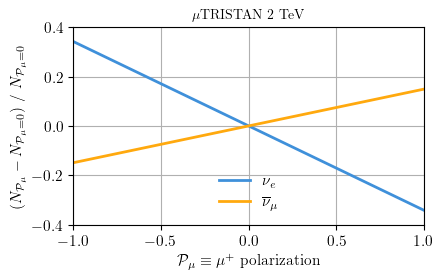

In [ ]:
fig, ax = pt.std_fig(figsize=(4.44, 2.6))

# ax.plot(Pols[mask], [sim.facecounts['Total','Total']/4 for sim in Pol_sims], label=r'Total/4', color='black')
ax.plot(Pols[mask], (Counts['nue_left']/np.mean(Counts['nue_left']) - 1), label=r'$\nu_e$', color=pt.cblind_safe_wheel[0], lw=2)
# ax.plot(Pols[mask], Counts['numubar_left']/np.mean(Counts['numubar_left']) - 1, label=r'$\overline\nu_\mu$', color=pt.cblind_safe_wheel[1], ls=(1,(3,1)))
# ax.plot(Pols[mask], Counts['nue_right']/np.mean(Counts['nue_right']) - 1, label=r'$\overline\nu_e$', color=pt.cblind_safe_wheel[0], ls=(1,(3,1)))
ax.plot(Pols[mask], (Counts['numubar_right']/np.mean(Counts['numubar_right']) - 1), label=r'$\overline\nu_\mu$', color=pt.cblind_safe_wheel[1], ls='-', lw=2)

# standard legend
leg1 = ax.legend(loc = 'lower center', ncols=1, fontsize=11)

# Create a new legend
# dark_line = plt.Line2D([], [], color='black', lw=LW, label=r'Total')
# light_line = plt.Line2D([], [], color='black', lw=LW, ls=(1,(3,1)), label=r'nozzles')
# leg2 = ax.legend(handles=[dark_line, light_line], loc='upper left')

# plt.gca().add_artist(leg1)
# plt.gca().add_artist(leg2)

ax.set_ylim(-0.4,0.4)
ax.set_xlim(-1,1)
# ax.vlines(0, -1, 1, color='black', ls='-', lw=0.5)
# ax.hlines(0, -1, 1, color='black', ls='-', lw=0.5)
ax.grid()
# ax.set_yscale('log')
ax.set_title('$\mu$TRISTAN 2 TeV', fontsize=10)
ax.set_xlabel(r'$\mathcal{P}_\mu \equiv \mu^+$ polarization')
ax.set_ylabel(r'($N_{\mathcal{P}_\mu} - N_{\mathcal{P}_\mu=0}$) / $N_{\mathcal{P}_\mu=0}$')
fig.savefig('plots/BIN_distributions/mutristan_pol_sensitivity.pdf', bbox_inches = 'tight', dpi = 400)

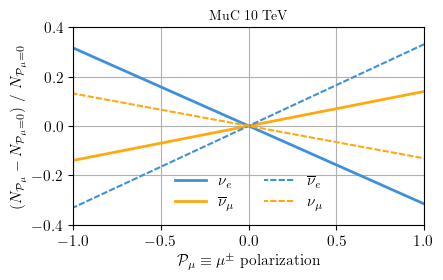

In [ ]:
fig, ax = pt.std_fig(figsize=(4.44, 2.6))

# ax.plot(Pols[mask], [sim.facecounts['Total','Total']/4 for sim in Pol_sims], label=r'Total/4', color='black')
ax.plot(Pols[mask], (Counts_10TeV['nue_left']/np.mean(Counts_10TeV['nue_left']) - 1), label=r'$\nu_e$', color=pt.cblind_safe_wheel[0], lw=2)
ax.plot(Pols[mask], (Counts_10TeV['numubar_left']/np.mean(Counts_10TeV['numubar_left']) - 1), label=r'$\overline\nu_\mu$', color=pt.cblind_safe_wheel[1], ls='-', lw=2)
ax.plot(Pols[mask], (Counts_10TeV['nuebar_right']/np.mean(Counts_10TeV['nuebar_right']) - 1), label=r'$\overline\nu_e$', color=pt.cblind_safe_wheel[0], ls=(1,(3,1)))
ax.plot(Pols[mask], (Counts_10TeV['numu_right']/np.mean(Counts_10TeV['numu_right']) - 1), label=r'$\nu_\mu$', color=pt.cblind_safe_wheel[1], ls=(1,(3,1)))

# standard legend
leg1 = ax.legend(loc = 'lower center', ncols=2, fontsize=11)

# Create a new legend
# dark_line = plt.Line2D([], [], color='black', lw=LW, label=r'Total')
# light_line = plt.Line2D([], [], color='black', lw=LW, ls=(1,(3,1)), label=r'nozzles')
# leg2 = ax.legend(handles=[dark_line, light_line], loc='upper left')

# plt.gca().add_artist(leg1)
# plt.gca().add_artist(leg2)

ax.set_ylim(-0.4,0.4)
ax.set_xlim(-1,1)
# ax.vlines(0, -1, 1, color='black', ls='-', lw=0.5)
# ax.hlines(0, -1, 1, color='black', ls='-', lw=0.5)
ax.grid()
# ax.set_yscale('log')
ax.set_title('MuC 10 TeV', fontsize=10)
ax.set_xlabel(r'$\mathcal{P}_\mu \equiv \mu^\pm$ polarization')
ax.set_ylabel(r'($N_{\mathcal{P}_\mu} - N_{\mathcal{P}_\mu=0}$) / $N_{\mathcal{P}_\mu=0}$')
fig.savefig('plots/BIN_distributions/muc10tev_pol_sensitivity.pdf', bbox_inches = 'tight', dpi = 400)

/var/folders/dl/ccbsfs591r1fhgcws28m8xy40000gn/T/ipykernel_12694/2078764903.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend(loc = 'upper right')


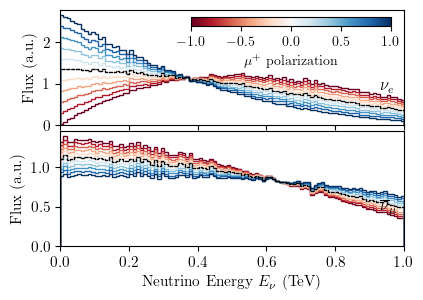

In [ ]:
import matplotlib as mpl

norm = mpl.colors.Normalize(vmin=Pols.min(), vmax=Pols.max())
cmap = mpl.cm.RdBu
colors = cmap(np.linspace(0, 1, len(Pols)))

# fig, ax = plt.
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=pt.std_figsize)

b = np.linspace(0, 1, 100)
for i in range(len(Pols)):
#     plt.hist(np.arccos(Cfv.get_cosTheta(Pol_sims[i].cco.pnumu)), color=colors[i], weights=Pol_sims[i].cco.weights, bins=b, histtype='step', zorder=1-i/100)
    if Pols[i] == 0:
        w = sim.mustorage_sims[1].reweigh_with_new_polarization(Pols[i])
        ax2.hist(1e-3*sim.mustorage_sims[1].pnu[:,0], weights=w/np.sum(w)*len(b), bins=b, histtype='step', color='black', ls=(1,(3,0.5)),label=r'$P = 0$', zorder=1.2)
        w = sim.mustorage_sims[0].reweigh_with_new_polarization(Pols[i])
        ax1.hist(1e-3*sim.mustorage_sims[0].pnu[:,0], weights=w/np.sum(w)*len(b), bins=b, histtype='step', color='black', ls=(1,(3,0.5)), zorder=1.2)

    else:
        w = sim.mustorage_sims[1].reweigh_with_new_polarization(Pols[i])
        ax2.hist(1e-3*sim.mustorage_sims[1].pnu[:,0], weights=w/np.sum(w)*len(b), bins=b, histtype='step', color=colors[i], zorder=1.1)
        w = sim.mustorage_sims[0].reweigh_with_new_polarization(Pols[i])
        ax1.hist(1e-3*sim.mustorage_sims[0].pnu[:,0], weights=w/np.sum(w)*len(b), bins=b, histtype='step', color=colors[i], zorder=1.1)

# plt.legend()
# fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
#              cax=ax, orientation='horizontal', label='Some Units')

ax2.set_xlim(b.min(), b.max())
ax1.set_ylabel(r'Flux (a.u.)')
ax2.set_ylabel(r'Flux (a.u.)')
ax2.set_xlabel(r'Neutrino Energy $E_{\nu}$ (TeV)')
ax1.legend(loc = 'upper right')

# cax = fig.add_axes([0.42, 0.43, 0.45, 0.03])
cax = fig.add_axes([0.42, 0.825, 0.45, 0.03])
cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), orientation="horizontal", cax=cax, ticklocation='bottom')
cbar.ax.tick_params(labelsize=10)
cbar.set_label(r'$\mu^+$ polarization', fontsize=10)  # Set the label font size
ax1.annotate(r'$\nu_e$', xy=(0.93, 0.3), xycoords='axes fraction', fontsize=12)
ax2.annotate(r'$\overline\nu_\mu$', xy=(0.93, 0.3), xycoords='axes fraction', fontsize=12)
plt.subplots_adjust(hspace=0.05)  # Change the value to adjust spacing
plt.savefig('plots/BIN_distributions/polarized_energy_dist.pdf', bbox_inches = 'tight', dpi = 500)

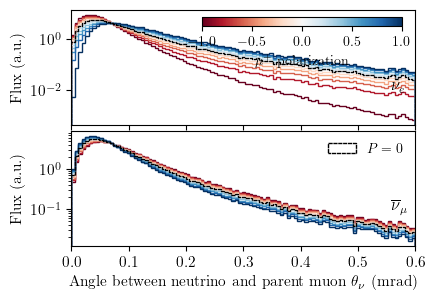

In [ ]:
norm = mpl.colors.Normalize(vmin=Pols.min(), vmax=Pols.max())
cmap = mpl.cm.RdBu
colors = cmap(np.linspace(0, 1, len(Pols)))

# fig, ax = plt.
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=pt.std_figsize)

b = np.linspace(0, 0.6, 100)
for i in range(len(Pols)):
    if Pols[i] == 0:
        w = sim.mustorage_sims[1].reweigh_with_new_polarization(Pols[i])
        ax2.hist(1e3*np.arccos(Cfv.get_cos_opening_angle(sim.mustorage_sims[1].pnu, sim.mustorage_sims[1].pmu)), weights=w/np.sum(w)*len(b), bins=b, histtype='step', color='black', ls=(1,(3,0.5)),label=r'$P = 0$', zorder=1.2)
        w = sim.mustorage_sims[0].reweigh_with_new_polarization(Pols[i])
        ax1.hist(1e3*np.arccos(Cfv.get_cos_opening_angle(sim.mustorage_sims[0].pnu, sim.mustorage_sims[0].pmu)), weights=w/np.sum(w)*len(b), bins=b, histtype='step', color='black', ls=(1,(3,0.5)), zorder=1.2)

    else:
        w = sim.mustorage_sims[1].reweigh_with_new_polarization(Pols[i])
        ax2.hist(1e3*np.arccos(Cfv.get_cos_opening_angle(sim.mustorage_sims[1].pnu, sim.mustorage_sims[1].pmu)), weights=w/np.sum(w)*len(b), bins=b, histtype='step', color=colors[i], zorder=1.1)
        w = sim.mustorage_sims[0].reweigh_with_new_polarization(Pols[i])
        ax1.hist(1e3*np.arccos(Cfv.get_cos_opening_angle(sim.mustorage_sims[0].pnu, sim.mustorage_sims[0].pmu)), weights=w/np.sum(w)*len(b), bins=b, histtype='step', color=colors[i], zorder=1.1)

ax2.set_xlim(b.min(), b.max())
# ax1.set_yscale('log')
# ax2.set_yscale('log')
ax1.set_ylabel(r'Flux (a.u.)')
ax2.set_ylabel(r'Flux (a.u.)')
ax2.set_xlabel(r'Angle between neutrino and parent muon $\theta_{\nu}$ (mrad)')
ax2.legend(loc = 'upper right')
cax = fig.add_axes([0.42, 0.825, 0.45, 0.03])
cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), orientation="horizontal", cax=cax, ticklocation='bottom')
cbar.ax.tick_params(labelsize=10)
cbar.set_label(r'$\mu^+$ polarization', fontsize=10)  # Set the label font size
ax1.annotate(r'$\nu_e$', xy=(0.93, 0.3), xycoords='axes fraction', fontsize=12)
ax2.annotate(r'$\overline\nu_\mu$', xy=(0.93, 0.3), xycoords='axes fraction', fontsize=12)

plt.subplots_adjust(hspace=0.05)  # Change the value to adjust spacing
plt.savefig('plots/BIN_distributions/polarized_angle_dist.pdf', bbox_inches = 'tight', dpi = 500)

## Estimate of probability for double neutrino interactions 

In [ ]:
sim = col_sims[2]
Nmudecays_in_acc = sim.bunchx_in_a_year/sim.n_turns*sim.design['Nmu_per_bunch']*0.003

Enu_avg = 2e3 # GeV

nTargetsPerCm = 3.72e24 # according to Luc
xSecNC = 1e-39 * Enu_avg
xSecCC = 0.6e-38 * Enu_avg
length1 = 300 # cm
length2 = 100 # cm

prob_single = nTargetsPerCm * (8e-39 * Enu_avg) * length1
elastic = 0.5
prob_double = nTargetsPerCm**2 * xSecNC * xSecCC * length1 * length2 * elastic

def Poisson(rate, k):
    return np.exp(-rate)*rate**k/np.prod(list(range(1,k+1)))

print(f'{prob_single*Nmudecays_in_acc:.2e}, {prob_double*Nmudecays_in_acc:.2e}, {Poisson(prob_single*Nmudecays_in_acc/sim.bunchx_in_a_year, 4):.2e}')

1.48e+10, 4.14e+00, 3.46e-15


## Loading GENIE data

Now we need the same number of events

In [206]:
NEVENTS = 1e5

col_designs_g = [col.muc_10tev, col.mut_2tev]
col_sims_g = []
for design in col_designs_g:
    if design == col.muc_10tev:
        sim = MuC.BINSimulator(design=design, N_evals = NEVENTS, save_mem=False, remove_ring_fraction=0.9, lattice='beam-optics/ring_v06_smoothed.pkl')
    elif design == col.mut_2tev:
        sim = MuC.BINSimulator(design=design, N_evals = NEVENTS, save_mem=False, remove_ring_fraction=0.9, lattice='beam-optics/ring_3tev_v1.2_smoothed.pkl')
    else:
        raise ValueError('Unknown design')
    col_sims_g.append(sim.run())

Efficiency of detector acceptance: 2.23e-01
Efficiency of detector acceptance: 2.21e-01
Efficiency of detector acceptance: 2.20e-01
Efficiency of detector acceptance: 2.21e-01
Total count: 1.52e+11 events;

Efficiency of detector acceptance: 3.85e-01
Efficiency of detector acceptance: 3.95e-01
Efficiency of detector acceptance: 3.83e-01
Efficiency of detector acceptance: 3.94e-01
Total count: 1.66e+11 events;



In [209]:
# data = col_sims[0].load_genie_events(['luc_analysis/Q2_mucols2_nue.txt','luc_analysis/Q2_mucols2_numu.txt'], n_events=1e5)
# data2 = col_sims[2].load_genie_events(['luc_analysis/muTs.txt'], n_events=1e5)
data2 = col_sims[2].load_genie_events(['luc_analysis/Q2_muTs.txt'], n_events=1e5)

Loading generated data for a muTs experiment;
It includes interactions from ν_e, anti ν_μ within the MD, SB, SM, HC, EC, NO of the muon detector.
Adding weights...
Done!


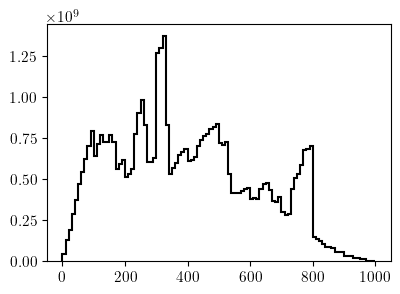

In [212]:
c2 = col_sims[2]
_=plt.hist(c2.genie_events['nu_E'][c2.genie_nue], weights=c2.genie_events['w'][c2.genie_nue], bins=100, histtype='step', lw=1.5, color='black')

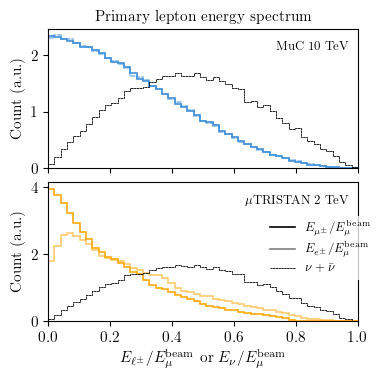

In [ ]:
import matplotlib.gridspec as gridspec

# Create figure and gridspec
fig = plt.figure(figsize=(4.0, 3.8))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1], hspace=0.1)
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax1.set_title(r'Primary lepton energy spectrum', fontsize=11)

LS = (1,(3,0.5))
LW = 1.2
yunits=1e9
bins = np.linspace(0,1,50)
DENS=True
light_factor=0.6
# First subplot
c1 = col_sims[0]
ax1.hist(c1.genie_events[c1.genie_e]['E'] / c1.design['beam_p0'], weights=c1.genie_events[c1.genie_e]['w'] / yunits,
         bins=bins, histtype='step', label='MuC 10 TeV', color=pt.cblind_safe_wheel[0], zorder=2, lw=LW, density=DENS)
ax1.hist(c1.genie_events[c1.genie_mu]['E'] / c1.design['beam_p0'], weights=c1.genie_events[c1.genie_mu]['w'] / yunits,
         bins=bins, histtype='step', color=pt.lighten_color(pt.cblind_safe_wheel[0],light_factor), zorder=2-0.1, ls=(1,(3,0.6)), lw=LW, density=DENS)
ax1.hist(c1.genie_events['nu_E'] / c1.design['beam_p0'], weights=c1.genie_events['w'] / yunits,
         bins=bins, histtype='step', color='black', zorder=2, lw=LW*0.5, ls=LS, density=DENS)

c2 = col_sims[2]
ax2.hist(c2.genie_events[c2.genie_e]['E'] / c2.design['beam_p0'], weights=c2.genie_events[c2.genie_e]['w'] / yunits,
         bins=bins, histtype='step', label=r'$\mu$TRISTAN', color=pt.cblind_safe_wheel[1], zorder=2, lw=LW, density=DENS)
ax2.hist(c2.genie_events[c2.genie_mu]['E'] / c2.design['beam_p0'], weights=c2.genie_events[c2.genie_mu]['w'] / yunits,
         bins=bins, histtype='step', color=pt.lighten_color(pt.cblind_safe_wheel[1],light_factor), zorder=2-0.1, lw=LW, density=DENS)
ax2.hist(c1.genie_events['nu_E'] / c1.design['beam_p0'], weights=c1.genie_events['w']/c1.genie_events['w'].sum()*c2.genie_events['w'].sum() / yunits,
         bins=bins, histtype='step', color='black', zorder=2, lw=LW*0.5, ls=LS, density=DENS)


ax1.set_ylabel(r'Count (a.u.)')
ax2.set_ylabel(r'Count (a.u.)')
ax2.set_xlabel(r'${E_{\ell^\pm}}/{E_\mu^{\rm beam}}$ or ${E_{\nu}}/{E_\mu^{\rm beam}}$')

# Loop over axes and annotate
labels=[r'MuC 10 TeV', r'$\mu$TRISTAN 2 TeV']
for i, ax in enumerate([ax1, ax2]):
    ax.text(0.97, 0.9, labels[i], transform=ax.transAxes,
            fontsize=9, verticalalignment='top', horizontalalignment='right')
    # ax.set_ylim(0.,0.3)

# Create a new legend
dark_line = plt.Line2D([], [], color='black', lw=LW, label=r'${E_{\mu^\pm}}/{E_\mu^{\rm beam}}$')
light_line = plt.Line2D([], [], color='gray', lw=LW, label=r'${E_{e^\pm}}/{E_\mu^{\rm beam}}$')
lighter_line = plt.Line2D([], [], color='black', zorder=2, lw=LW*0.5, ls=LS, label=r'${E_{\nu}}/{E_\mu^{\rm beam}}$')
leg2 = ax2.legend(handles=[dark_line, light_line, lighter_line], loc=(0.7, 0.3), title='', fontsize=9, frameon=True, framealpha=0.75, edgecolor='None')
# leg2 = ax3.legend(handles=[dark_line, light_line], loc=(0.79, 0.1), title='', fontsize=10, frameon=True, framealpha=0.75)

ax1.set_xlim(0, 1)
ax2.set_xlim(0, 1)

# Adjust labels and layout
plt.setp(ax1.get_xticklabels(), visible=False)
plt.savefig('plots/BIN_distributions/lepton_energy.pdf', bbox_inches = 'tight', dpi = 500)

In [224]:
def get_angle(df):
    return np.arccos(df['pz']/np.sqrt(df['px']**2 + df['py']**2 + df['pz']**2))

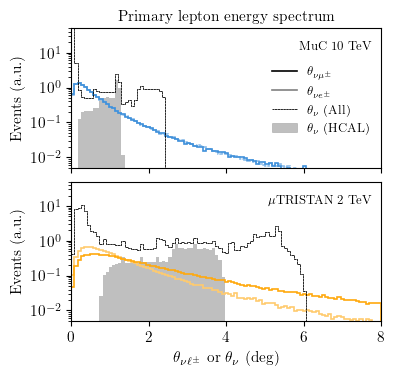

In [266]:
import matplotlib.gridspec as gridspec

# Create figure and gridspec
fig = plt.figure(figsize=(4.0, 3.8))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1], hspace=0.1)
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax1.set_title(r'Primary lepton energy spectrum', fontsize=11)

LS = (1,(3,0.5))
LW = 1.2
yunits=1e9
bins = np.linspace(0,8,100)
yunits=1e9
xunits=180/np.pi

DENS=True
light_factor=0.6
# First subplot

c1 = col_sims[0]

ax1.hist(get_angle(c1.genie_events[c1.genie_e]) * xunits, weights=c1.genie_events[c1.genie_e]['w'] / yunits,
         bins=bins, histtype='step', label='MuC 10 TeV', color=pt.cblind_safe_wheel[0], zorder=2, lw=LW, density=DENS)
ax1.hist(get_angle(c1.genie_events[c1.genie_mu]) * xunits, weights=c1.genie_events[c1.genie_mu]['w'] / yunits,
         bins=bins, histtype='step', color=pt.lighten_color(pt.cblind_safe_wheel[0],light_factor), zorder=2-0.1, ls=(1,(3,0.6)), lw=LW, density=DENS)



x, y, z, w, times, Enu, costheta = c1.get_data(sec = 'all')
newunits = w.sum()/bins.size
ax1.hist(np.arccos(costheta)*180/np.pi, weights=w / newunits,
         bins=bins, histtype='step', color='black', zorder=2, lw=LW*0.5, ls=LS, density=False)
x, y, z, w, times, Enu, costheta = c1.get_data(sec = 'hcal')
ax1.hist(np.arccos(costheta)*180/np.pi, weights=w / newunits,
         bins=bins, histtype='stepfilled', color='grey', zorder=0, lw=0.5, alpha=0.5, density=False)

c2 = col_sims[2]

ax2.hist(get_angle(c2.genie_events[c2.genie_e]) * xunits, weights=c2.genie_events[c2.genie_e]['w'] / yunits,
         bins=bins, histtype='step', label=r'$\mu$TRISTAN', color=pt.cblind_safe_wheel[1], zorder=2, lw=LW, density=DENS)
ax2.hist(get_angle(c2.genie_events[c2.genie_mu]) * xunits, weights=c2.genie_events[c2.genie_mu]['w'] / yunits,
         bins=bins, histtype='step', color=pt.lighten_color(pt.cblind_safe_wheel[1],light_factor), zorder=2-0.1, lw=LW, density=DENS)

x, y, z, w, times, Enu, costheta = c2.get_data(sec = 'all')
newunits = w.sum()/bins.size
ax2.hist(np.arccos(costheta)*180/np.pi, weights=w/newunits,
         bins=bins, histtype='step', color='black', zorder=2, lw=LW*0.5, ls=LS, density=False)

x, y, z, w, times, Enu, costheta = c2.get_data(sec = 'hcal')
ax2.hist(np.arccos(costheta)*180/np.pi, weights=w / newunits,
         bins=bins, histtype='stepfilled', color='grey', zorder=0, lw=0.5, alpha=0.5, density=False)


ax1.set_ylabel(r'Events (a.u.)')
ax2.set_ylabel(r'Events (a.u.)')
ax2.set_xlabel(r'$\theta_{\nu\ell^\pm}$ or $\theta_\nu$ (deg)')

# Loop over axes and annotate
labels=[r'MuC 10 TeV', r'$\mu$TRISTAN 2 TeV']
for i, ax in enumerate([ax1, ax2]):
    ax.text(0.97, 0.9, labels[i], transform=ax.transAxes,
            fontsize=9, verticalalignment='top', horizontalalignment='right')
    ax.set_yscale('log')
    ax.set_ylim(0.5e-2, 50)

# Create a new legend
dark_line = plt.Line2D([], [], color='black', lw=LW, label=r'$\theta_{\nu\mu^\pm}$')
light_line = plt.Line2D([], [], color='gray', lw=LW, label=r'$\theta_{\nu e^\pm}$')
lighter_line = plt.Line2D([], [], color='black', zorder=2, lw=LW*0.5, ls=LS, label=r'$\theta_\nu$ (All)')
filled_hist = plt.fill_between([], [], color='grey', alpha=0.5, zorder=2, lw=0.5, label=r'$\theta_\nu$ (HCAL)')
leg2 = ax1.legend(handles=[dark_line, light_line, lighter_line, filled_hist], loc=(0.63, 0.2), title='', fontsize=9, frameon=True, framealpha=0.75, edgecolor='None')

ax1.set_xlim(bins.min(), bins.max())
ax2.set_xlim(bins.min(), bins.max())

# Adjust labels and layout
plt.setp(ax1.get_xticklabels(), visible=False)
plt.savefig('plots/BIN_distributions/lepton_angle.pdf', bbox_inches = 'tight', dpi = 500)